In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow as tf
#import tensorflow_probability as tfp
import scanpy as sc

print()
print("numpy version "+np.__version__)
print("tensorflow version "+tf.__version__)
#print("tensorflow_probability version "+tfp.__version__)


import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)


Bad key "text.kerning_factor" on line 4 in
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Fra


numpy version 1.18.2
tensorflow version 1.14.0
batchglm version v0.6.8
diffpy version v0.6.13


# load annotated data

The processed file has all the annotations, including the 1D spatial scores.

In [2]:
annot = sc.read_h5ad('/Users/yolanda/Documents/projects/spatial-genomics/data/Processed_Liver_All_Batches_mouse_deconV2_spatial.h5ad')

The raw counts file is the decontaminated data without log normalizing.

In [3]:
adata_matrix = sc.read_h5ad('/Users/yolanda/Documents/projects/spatial-genomics/data/Liver_All_Batches_mouse_deconV2_raw_counts.h5ad')

Among 24914 mm10 transcripts and 5434 cells, filter to retain genes with high expression, and then select the top 2000 most variable genes. 

R scripts:

dim(liver_mat) # 24917 genes by 5434 cells

genes_to_keep <- which(rowSums(edgeR::cpm(liver_mat) > 5) >= 15)

liver_mat_filter_raw <- liver_mat[genes_to_keep, ]

convert to log 2 counts per million

liver_mat_log2 <- edgeR::cpm(liver_mat_filter_raw, log = TRUE)

dim(liver_mat_log2) # 14222 by 5434

Calc_CV <- function(x){sd(x) / mean(x)}

liver_gene_cv <- apply(liver_mat_log2, 1, Calc_CV)

summary(liver_gene_cv)

liver_mat_filter <- liver_mat_log2[which(rank(liver_gene_cv) > length(liver_gene_cv) - 2000), ]

In [4]:
num_genes = 5000 # 2000 or 5000
top_variable_genes = pd.read_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/fig4c_top_genes/top_%i_genes.csv' %num_genes)
top_variable_genes['x']

0        mm10_Lypla1
1       mm10_Gm37988
2       mm10_Atp6v1h
3        mm10_Rb1cc1
4        mm10_Pcmtd1
            ...     
4995     mm10_Zfp950
4996     mm10_mt-Co1
4997     mm10_mt-Nd5
4998       mm10_PISD
4999      mm10_DHRSX
Name: x, Length: 5000, dtype: object

In [5]:
adata = adata_matrix[adata_matrix.obs.index.isin(annot.obs.index.to_list())]

In [6]:
##set annotations
adata.obs = annot.obs

adata.uns = annot.uns

In [7]:
adata

AnnData object with n_obs × n_vars = 5434 × 55287 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

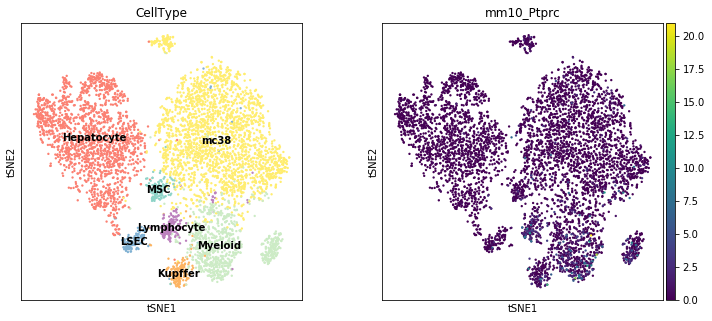

In [8]:
plt.rcParams['figure.figsize'] = [5, 5]

sc.pl.tsne(adata,
          color=['CellType','mm10_Ptprc'],
          legend_loc = 'on data'
          )


In [9]:
## convert float32 matrix to integers 
adata.X =  adata.X.astype(int) 

In [10]:
adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
adata

AnnData object with n_obs × n_vars = 5434 × 55287 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [12]:
##log normalize 
adata = sc.pp.log1p(adata, copy=True)

In [13]:
## name continuous variable "time" - necessary for diffxpy bug
adata.obs['time'] = adata.obs['prox_2']

In [14]:
##filter out human genes

adata = adata[:,adata.var_names.str.startswith('mm10_')]
adata

View of AnnData object with n_obs × n_vars = 5434 × 24917 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1', 'time'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [15]:
## filter to retain top most variable genes
adata = adata[:, top_variable_genes['x']]
adata

View of AnnData object with n_obs × n_vars = 5434 × 5000 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1', 'time'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [16]:
## remove cell with nan prox_2 values
adata = adata[~adata.obs['time'].isnull()]

In [17]:
##create species specific matricies

adata_Myeloid = adata[adata.obs['CellType'] == 'Myeloid']

adata_lymphocyte = adata[adata.obs['CellType'] == 'Lymphocyte']

adata_hepatocyte = adata[adata.obs['CellType'] == 'Hepatocyte']

adata_mc38 = adata[adata.obs['CellType'] == 'mc38']


In [18]:

##reassign to fix other diffxpy bug


## name continuous variable "time" - necessary for diffxpy bug
adata_hepatocyte.obs['time'] = adata_hepatocyte.obs['prox_2']

adata_mc38.obs['time'] = adata_mc38.obs['prox_2']

adata_Myeloid.obs['time'] = adata_Myeloid.obs['prox_2']



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [25]:
# filter cells based on 1d proximity score
adata_Myeloid = adata_Myeloid[adata_Myeloid.obs['time'] < 0.6]
adata_mc38 = adata_mc38[adata_mc38.obs['time'] < 0.6]
adata_hepatocyte = adata_hepatocyte[adata_hepatocyte.obs['time'] > 0.4]

In [26]:
### fix integer issue - after log transforming

adata_hepatocyte.X =  adata_hepatocyte.X.astype(int) 

adata_mc38.X =  adata_mc38.X.astype(int) 

adata_Myeloid.X =  adata_Myeloid.X.astype(int) 

In [29]:
adata_Myeloid.X

ArrayView([[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 1, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]])

In [30]:
det_mc38 = de.test.continuous_1d(   
    data=adata_mc38.X,    
    
    sample_description=adata_mc38.obs,
    
    gene_names=adata_mc38.var_names,
    
    formula_loc="~ 1 + time + batch",
    
    formula_scale="~ 1 + batch",
    
    factor_loc_totest="time",

    continuous="time",
#    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
    df=4,
    quick_scale= False
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Step: 0 loss: 743.348147 models converged 0
INFO:tensorflow:Step: 1 loss: 731.104117, converged 121 in 3.189 sec., updated 4964, {f: 0, g: 121, x: 0}
INFO:tensorflow:Step: 2 loss: 729.287565, converged 121 in 2.536 sec., updated 4618, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 728.934955, converged 121 in 2.684 sec., updated 4633, {f: 0, g: 0, x: 0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/batchglm/train/tf/base/estimator.py:285: RuntimeWarning: invalid value encountered in true_divide
  ll_converged = (ll_prev - ll_current) / ll_prev < pkg_constants.LLTOL_BY_FEATURE
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/batchglm/train/tf/base/estimator.py:285: RuntimeWarning: invalid value encountered in less
  ll_converged = (ll_prev - ll_current) / ll_prev < pkg_constants.LLTOL_BY_FEATURE


INFO:tensorflow:Step: 4 loss: 728.800083, converged 121 in 2.665 sec., updated 4630, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 728.725142, converged 121 in 2.669 sec., updated 4631, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 6 loss: 728.677764, converged 121 in 2.626 sec., updated 4630, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 7 loss: 728.643897, converged 121 in 2.829 sec., updated 4630, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 8 loss: 728.615996, converged 121 in 2.789 sec., updated 4628, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 9 loss: 728.591067, converged 121 in 2.71 sec., updated 4624, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 10 loss: 728.567498, converged 121 in 2.758 sec., updated 4619, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 11 loss: 728.544387, converged 121 in 2.659 sec., updated 4623, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 12 loss: 728.521579, converged 121 in 2.79 sec., updated 4623, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 13 loss: 728.493059, converged 121 in 2.6

In [31]:
det_mc38.summary()

,gene,pval,qval,log2fc,mean,zero_mean,grad,ll
0,mm10_Lypla1,0.728382,1.000000,3.087419,0.012172,False,0.000894,-132.502160
1,mm10_Gm37988,0.551629,0.984348,1.589770,0.017322,False,0.001418,-176.107813
2,mm10_Atp6v1h,0.646378,0.996587,1.384110,0.020599,False,0.002079,-187.633434
3,mm10_Rb1cc1,0.779457,1.000000,1.130732,0.055243,False,0.004677,-430.297341
4,mm10_Pcmtd1,0.592146,0.988501,4.156368,0.021536,False,0.001440,-205.045019
...,...,...,...,...,...,...,...,...
4995,mm10_Zfp950,0.832431,1.000000,1.994940,0.019195,False,0.001909,-186.264723
4996,mm10_mt-Co1,0.581983,0.988501,2.031426,0.035112,False,0.002158,-303.626727
4997,mm10_mt-Nd5,0.753826,1.000000,1.477060,0.056648,False,0.002213,-439.401867
4998,mm10_PISD,0.106206,0.766238,1.116461,0.181648,False,0.005935,-1071.436522


In [32]:
# det_mc38.summary().to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/det_mc38_%i.csv' %num_genes)
det_mc38.summary().to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_det_mc38_%i.csv' %num_genes)

In [34]:
det_hepatocyte = de.test.continuous_1d(   
    data=adata_hepatocyte.X,    
    
    sample_description=adata_hepatocyte.obs,
    
    gene_names=adata_hepatocyte.var_names,
    
    formula_loc="~ 1 + time + batch",
    
    formula_scale="~ 1 + batch",
    
    factor_loc_totest="time",

    continuous="time",
#    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
    df=4,
    quick_scale=False   
)

INFO:tensorflow:Step: 0 loss: 660.669400 models converged 0
INFO:tensorflow:Step: 1 loss: 649.722658, converged 143 in 2.449 sec., updated 4687, {f: 0, g: 143, x: 0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/batchglm/train/tf/base/estimator.py:285: RuntimeWarning: invalid value encountered in true_divide
  ll_converged = (ll_prev - ll_current) / ll_prev < pkg_constants.LLTOL_BY_FEATURE
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/batchglm/train/tf/base/estimator.py:285: RuntimeWarning: invalid value encountered in less
  ll_converged = (ll_prev - ll_current) / ll_prev < pkg_constants.LLTOL_BY_FEATURE


INFO:tensorflow:Step: 2 loss: 647.316940, converged 143 in 2.111 sec., updated 3900, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 646.421966, converged 143 in 2.139 sec., updated 3954, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 645.882075, converged 143 in 2.029 sec., updated 4011, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 645.564081, converged 143 in 2.191 sec., updated 4018, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 6 loss: 645.373635, converged 143 in 2.086 sec., updated 4013, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 7 loss: 645.268940, converged 143 in 2.029 sec., updated 4001, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 8 loss: 645.223190, converged 143 in 2.099 sec., updated 3952, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 9 loss: 645.199553, converged 143 in 2.2 sec., updated 3904, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 10 loss: 645.182826, converged 143 in 2.113 sec., updated 3896, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 11 loss: 645.169733, converged 143 in 2.113

In [35]:
# det_hepatocyte.summary().to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/det_hepatocyte_%i.csv' %num_genes)
det_hepatocyte.summary().to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_det_hepatocyte_%i.csv' %num_genes)

In [37]:
det_Myeloid = de.test.continuous_1d(   
    data=adata_Myeloid.X,    
    
    sample_description=adata_Myeloid.obs,
    
    gene_names=adata_Myeloid.var_names,
    
    formula_loc="~ 1 + time + batch",
    
    formula_scale="~ 1 + batch",
    
    factor_loc_totest="time",

    continuous="time",
#    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
    df=4,
    quick_scale= False  
)

INFO:tensorflow:Step: 0 loss: 793.140290 models converged 0
INFO:tensorflow:Step: 1 loss: 774.534691, converged 282 in 1.637 sec., updated 4893, {f: 0, g: 282, x: 0}
INFO:tensorflow:Step: 2 loss: 769.776344, converged 282 in 1.056 sec., updated 4026, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 767.915729, converged 282 in 1.011 sec., updated 4067, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 766.978024, converged 282 in 1.021 sec., updated 4092, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 766.453149, converged 282 in 1.036 sec., updated 4091, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 6 loss: 766.150498, converged 282 in 1.032 sec., updated 4089, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 7 loss: 765.972720, converged 282 in 1.03 sec., updated 4084, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 8 loss: 765.878957, converged 282 in 1.03 sec., updated 4060, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 9 loss: 765.827380, converged 282 in 1.019 sec., updated 4043, {f: 0, g: 0, x: 0}
INFO

In [38]:
# det_Myeloid.summary().to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/det_Myeloid_%i.csv' %num_genes)
det_Myeloid.summary().to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_det_Myeloid_%i.csv' %num_genes)

In [39]:
num_genes

5000

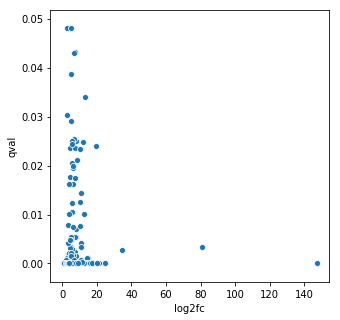

In [40]:
sns.scatterplot(data=det_Myeloid.summary()[det_Myeloid.summary()['qval'] <= 0.05],
               x='log2fc',
               y='qval')

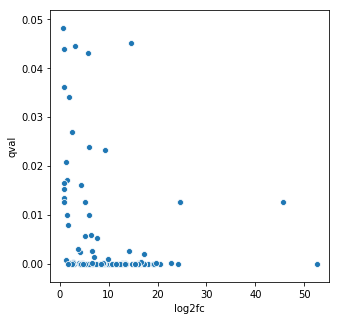

In [41]:
sns.scatterplot(data=det_mc38.summary()[det_mc38.summary()['qval'] <= 0.05],
               x='log2fc',
               y='qval')

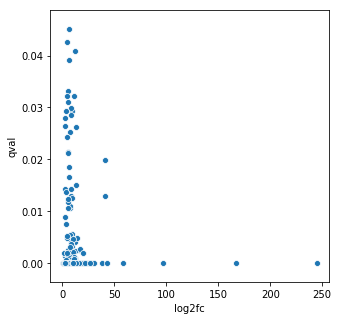

In [42]:
sns.scatterplot(data=det_hepatocyte.summary()[det_hepatocyte.summary()['qval'] <= 0.05],
               x='log2fc',
               y='qval')

In [43]:
# 'mm10_Tgfbi','mm10_Rpl8','mm10_Cd74','mm10_Hsp90ab1','mm10_Rnf213' 
# 'mm10_Zbtb20','mm10_Ghr','mm10_Dpyd','mm10_Adk','mm10_Akap9','mm10_Xist','mm10_Col1a2','mm10_Plcb1','mm10_Exoc4 mm10_St3gal4 mm10_Pnisr mm10_Foxp1 mm10_Gpc6 mm10_AY036118 mm10_Immp2l mm10_Chd9 mm10_Ly6e 
# 'mm10_Lgals1','mm10_B2m','mm10_Rpsa','mm10_Vim 
# 'mm10_Plec','mm10_Ahnak mm10_Tcf20','mm10_Cdk6','mm10_Rrbp1','mm10_Serbp1','mm10_Ncl 
# 'mm10_Zfpm2','mm10_Dpysl3','mm10_Samd4','mm10_Zfhx3','mm10_Fam19a1','mm10_Luc7l3','mm10_Pakap','mm10_Slit2 mm10_Myo10 
# 'mm10_Cald1','mm10_Erdr1','mm10_Gnas
# 'mm10_Airn','mm10_Tcf4','mm10_Smg6','mm10_Cpq','mm10_Ldlrad4','mm10_Dclk1','mm10_PISD','mm10_Kif26b','mm10_Trps1','mm10_Nfia','mm10_Sdc2','mm10_Pde4d
# 'mm10_Col3a1','mm10_Rpl4','mm10_Myh9','mm10_Smc4','mm10_Dst','mm10_Whsc1 

In [44]:
##qval cutoff
gene_frame_Myeloid = det_Myeloid.summary()[det_Myeloid.summary().sort_values('qval', )['qval'] <= 0.05]
gene_frame_mc38 = det_mc38.summary()[det_mc38.summary().sort_values('qval', )['qval'] <= 0.05]

gene_frame_hepatocyte = det_hepatocyte.summary()[det_hepatocyte.summary().sort_values('qval', )['qval'] <= 0.05]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [45]:
num_genes

5000

In [46]:
##fold change cutoff
gene_frame_2_Myeloid = gene_frame_Myeloid[gene_frame_Myeloid.log2fc >= 2]
gene_frame_2_mc38 = gene_frame_mc38[gene_frame_mc38.log2fc >= 2]
gene_frame_2_hepatocyte = gene_frame_hepatocyte[gene_frame_hepatocyte.log2fc >= 2]

In [47]:
#gene_frame_2 = gene_frame_2[gene_frame_2.grad < 0.02]

In [48]:
#gene_frame_2 = gene_frame_2[gene_frame_2.log2fc < 7]

In [49]:
#get gene ids in list


gene_idx_Myeloid = det_Myeloid._idx_genes(
    
    genes=gene_frame_2_Myeloid['gene'].tolist()

)

gene_idx_mc38 = det_mc38._idx_genes(
    
    genes=gene_frame_2_mc38['gene'].tolist()

)

gene_idx_hepatocyte = det_hepatocyte._idx_genes(
    
    genes=gene_frame_2_hepatocyte['gene'].tolist()

)

gene_idx_hepatocyte

array([  18,   28,   64,  118,  138,  141,  143,  149,  159,  162,  165,
        175,  179,  198,  207,  219,  261,  267,  277,  282,  285,  286,
        300,  303,  366,  367,  369,  380,  397,  422,  449,  452,  469,
        477,  481,  537,  550,  571,  578,  593,  597,  623,  625,  627,
        635,  643,  650,  653,  667,  675,  682,  689,  703,  712,  727,
        773,  778,  804,  814,  836,  851,  854,  869,  915,  926,  930,
        936,  942,  954,  956,  963,  970,  985,  992, 1001, 1003, 1008,
       1031, 1079, 1087, 1094, 1102, 1109, 1127, 1132, 1133, 1135, 1153,
       1187, 1191, 1197, 1198, 1229, 1239, 1265, 1267, 1271, 1274, 1299,
       1301, 1341, 1344, 1350, 1354, 1359, 1375, 1388, 1390, 1401, 1410,
       1418, 1420, 1449, 1451, 1456, 1472, 1475, 1479, 1490, 1492, 1495,
       1502, 1516, 1521, 1532, 1549, 1556, 1558, 1568, 1569, 1575, 1580,
       1581, 1601, 1614, 1623, 1625, 1653, 1663, 1664, 1690, 1697, 1703,
       1704, 1709, 1717, 1719, 1728, 1731, 1737, 17

In [50]:
# pd.Series(gene_idx_Myeloid).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/gene_idx_Myeloid_%i.csv' %num_genes)
# pd.Series(gene_idx_mc38).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/gene_idx_mc38_%i.csv' %num_genes)
# pd.Series(gene_idx_hepatocyte).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/gene_idx_hepatocyte_%i.csv' %num_genes)
pd.Series(gene_idx_Myeloid).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_gene_idx_Myeloid_%i.csv' %num_genes)
pd.Series(gene_idx_mc38).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_gene_idx_mc38_%i.csv' %num_genes)
pd.Series(gene_idx_hepatocyte).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_gene_idx_hepatocyte_%i.csv' %num_genes)

In [51]:
### get continuous interpolation
xcoord_Myeloid, data_Myeloid = det_Myeloid._continuous_interpolation(idx=gene_idx_Myeloid)
xcoord_mc38, data_mc38 = det_mc38._continuous_interpolation(idx=gene_idx_mc38)
xcoord_hepatocyte, data_hepatocyte = det_hepatocyte._continuous_interpolation(idx=gene_idx_hepatocyte)

In [52]:
# pd.DataFrame(data_Myeloid).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/data_Myeloid_%i.csv' %num_genes)
# pd.DataFrame(data_mc38).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/data_mc38_%i.csv' %num_genes)
# pd.DataFrame(data_hepatocyte).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/data_hepatocyte_%i.csv' %num_genes)
pd.DataFrame(data_Myeloid).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_data_Myeloid_%i.csv' %num_genes)
pd.DataFrame(data_mc38).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_data_mc38_%i.csv' %num_genes)
pd.DataFrame(data_hepatocyte).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_data_hepatocyte_%i.csv' %num_genes)

In [53]:
# pd.DataFrame(xcoord_Myeloid).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/xcoord_Myeloid_%i.csv' %num_genes)
# pd.DataFrame(xcoord_mc38).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/xcoord_mc38_%i.csv' %num_genes)
# pd.DataFrame(xcoord_hepatocyte).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/xcoord_hepatocyte_%i.csv' %num_genes)
pd.DataFrame(xcoord_Myeloid).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_xcoord_Myeloid_%i.csv' %num_genes)
pd.DataFrame(xcoord_mc38).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_xcoord_mc38_%i.csv' %num_genes)
pd.DataFrame(xcoord_hepatocyte).to_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/det_objects/filter_score_xcoord_hepatocyte_%i.csv' %num_genes)

In [54]:
### after tranforming, data has number of values, equal to filtered results
data_Myeloid = data_Myeloid.T
data_mc38 = data_mc38.T
data_hepatocyte = data_hepatocyte.T

In [55]:
temp_Myeloid=pd.DataFrame(data_Myeloid)
temp_mc38=pd.DataFrame(data_mc38)
temp_hepatocyte=pd.DataFrame(data_hepatocyte)

In [56]:
temp_Myeloid.index = det_Myeloid.summary().iloc[list(gene_idx_Myeloid)]['gene'].str[5:]
temp_mc38.index = det_mc38.summary().iloc[list(gene_idx_mc38)]['gene'].str[5:]
temp_hepatocyte.index = det_hepatocyte.summary().iloc[list(gene_idx_hepatocyte)]['gene'].str[5:]

In [57]:
##max value across columns 
# sort_order = temp.idxmax(axis=1)
# sort_order=sort_order.sort_values().index

# temp = temp.reindex(sort_order)

In [58]:
# temp.inde

In [59]:
temp_2_Myeloid = temp_Myeloid.div(temp_Myeloid.sum(axis=1), axis=0)
temp_2_mc38 = temp_mc38.div(temp_mc38.sum(axis=1), axis=0)
temp_2_hepatocyte = temp_hepatocyte.div(temp_hepatocyte.sum(axis=1), axis=0)

In [60]:
temp_3_Myeloid=temp_2_Myeloid[~(temp_2_Myeloid > 0.02).any(1)]
temp_3_mc38=temp_2_mc38[~(temp_2_mc38 > 0.02).any(1)]
temp_3_hepatocyte=temp_2_hepatocyte[~(temp_2_hepatocyte > 0.02).any(1)]

In [61]:
temp_3_Myeloid.shape

(34, 100)

In [62]:
temp_3_mc38.shape

(7, 100)

In [63]:
temp_3_hepatocyte.shape

(29, 100)

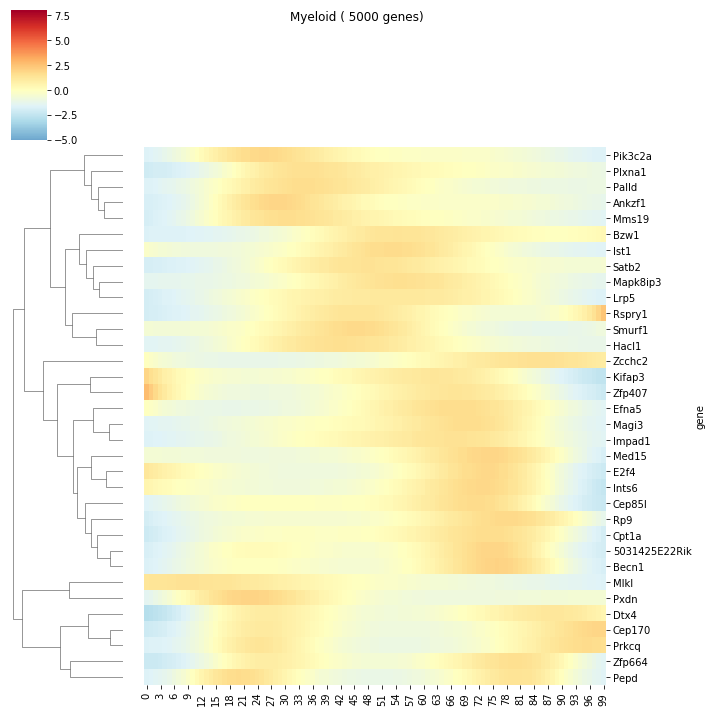

In [64]:
plt.rcParams['figure.figsize'] = [10, 20]

# z_scoreint or None, optional
# Either 0 (rows) or 1 (columns).





g_Myeloid =sns.clustermap(data=temp_3_Myeloid,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )
g_Myeloid.fig.suptitle('Myeloid ( %i genes)' %num_genes) 

# plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_Myeloid_%i.svg' %num_genes, bbox_inches='tight')
# plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_Myeloid_%i.png' %num_genes, bbox_inches='tight')

plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/filter_score_heatmap_spatial_Myeloid_%i.svg' %num_genes, bbox_inches='tight')
plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/filter_score_heatmap_spatial_Myeloid_%i.png' %num_genes, bbox_inches='tight')

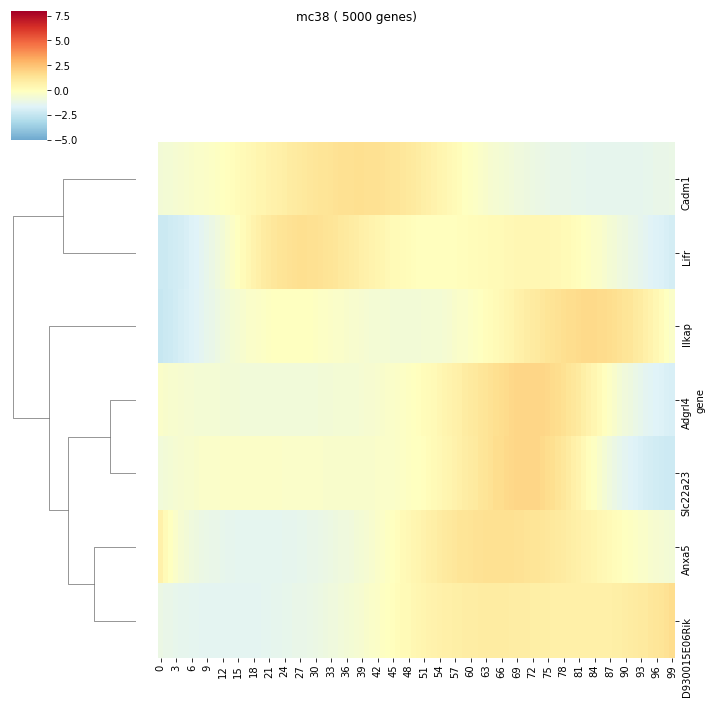

In [65]:
g_mc38 =sns.clustermap(data=temp_3_mc38,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )
g_mc38.fig.suptitle('mc38 ( %i genes)' %num_genes) 

# plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_mc38_%i.svg' %num_genes, bbox_inches='tight')
# plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_mc38_%i.png' %num_genes, bbox_inches='tight')

plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/filter_score_heatmap_spatial_mc38_%i.svg' %num_genes, bbox_inches='tight')
plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/filter_score_heatmap_spatial_mc38_%i.png' %num_genes, bbox_inches='tight')


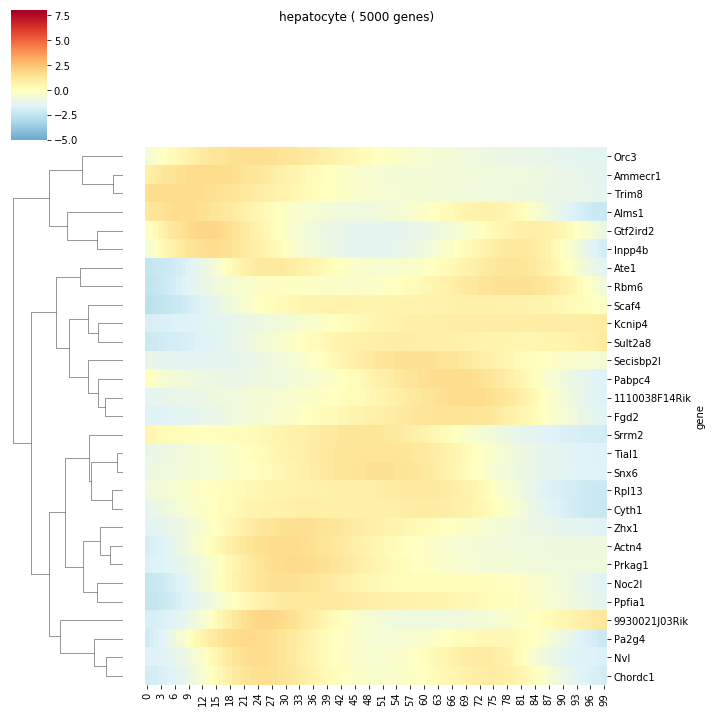

In [66]:
g_hepatocyte =sns.clustermap(data=temp_3_hepatocyte,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )
g_hepatocyte.fig.suptitle('hepatocyte ( %i genes)' %num_genes) 

# plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_hepatocyte_%i.svg' %num_genes, bbox_inches='tight')
# plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_hepatocyte_%i.png' %num_genes, bbox_inches='tight')

plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/filter_score_heatmap_spatial_hepatocyte_%i.svg' %num_genes, bbox_inches='tight')
plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/filter_score_heatmap_spatial_hepatocyte_%i.png' %num_genes, bbox_inches='tight')


Yutong did not revise the scripts below yet. 

TBC ... 

-------------------------------------------------------

In [801]:
from gprofiler import GProfiler


In [858]:
gp = GProfiler(return_dataframe=True)
gp.profile(organism='mmusculus',
            query=group_1
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,HP,HP:0003564,Folate-dependent fragile site at Xq28,0.049859,True,The presence of a folate sensitive fragile sit...,1,1,1,4457,1.0,1.0,query_1,[HP:0040012]
1,HP,HP:0008640,Congenital macroorchidism,0.049859,True,Congenital macroorchidism,1,1,1,4457,1.0,1.0,query_1,[HP:0000053]


In [859]:
gp.profile(organism='mmusculus',
            query=group_2
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents


In [860]:
gp.profile(organism='mmusculus',
            query=group_3
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,CORUM,CORUM:7492,Bcl2-Becn1 complex,0.049746,True,Bcl2-Becn1 complex,2,1,1,1058,1.0,0.5,query_1,[CORUM:0000000]


In [861]:
gp.profile(organism='mmusculus',
            query=group_4
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:1904888,cranial skeletal system development,0.002028,True,"""The process whose specific outcome is the pro...",68,25,4,21331,0.16,0.058824,query_1,[GO:0048856]
1,GO:BP,GO:0048704,embryonic skeletal system morphogenesis,0.009522,True,"""The process in which the anatomical structure...",100,25,4,21331,0.16,0.040000,query_1,"[GO:0048562, GO:0048705, GO:0048706]"
2,GO:BP,GO:0048706,embryonic skeletal system development,0.029475,True,"""The process, occurring during the embryonic p...",133,25,4,21331,0.16,0.030075,query_1,"[GO:0001501, GO:0043009]"
3,GO:BP,GO:0048701,embryonic cranial skeleton morphogenesis,0.042417,True,"""The process in which the anatomical structure...",48,25,3,21331,0.12,0.062500,query_1,"[GO:0048704, GO:1904888]"


In [845]:
color_list = []

from pylab import *

cmap = cm.get_cmap('Set3', 20)

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_list.append(matplotlib.colors.rgb2hex(rgb))
    print(matplotlib.colors.rgb2hex(rgb))

#8dd3c7
#8dd3c7
#ffffb3
#ffffb3
#bebada
#fb8072
#fb8072
#80b1d3
#fdb462
#fdb462
#b3de69
#b3de69
#fccde5
#d9d9d9
#d9d9d9
#bc80bd
#ccebc5
#ccebc5
#ffed6f
#ffed6f


In [846]:
###expand colors of dendrogram link

import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy

hierarchy.set_link_color_palette(color_list)

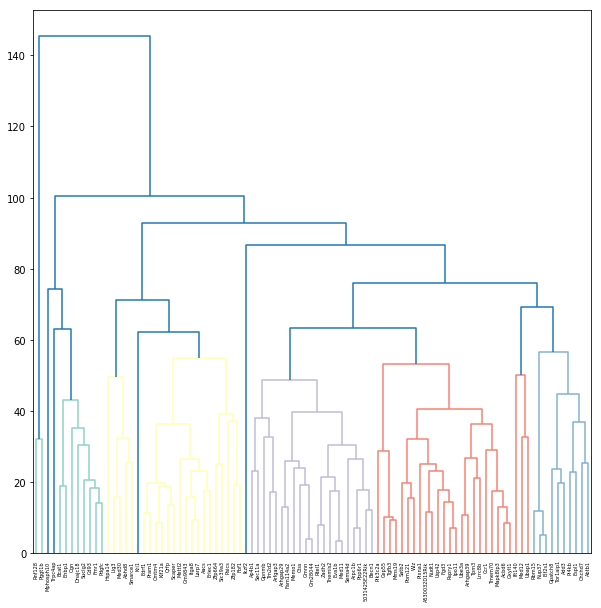

In [849]:
plt.rcParams['figure.figsize'] = [10, 10]

den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_row.linkage,
                                         labels = temp_3.index,
                                         color_threshold=60)  



In [850]:
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

In [851]:
clusters = get_cluster_classes(den)

cluster = []
for i in temp_3.index:
    included=False
    for j in clusters.keys():
        if i in clusters[j]:
            cluster.append(j)
            included=True
    if not included:
        cluster.append(None)

# df["cluster"] = cluster

In [852]:
len(clusters.keys()) # ['#8000ff']

6

In [853]:
import pandas as pd

In [854]:
valuesA = []


for key, value in clusters.items():
    for indexx in value:
        temp = [indexx, key]
        valuesA.append(temp)

In [855]:
index_color = pd.DataFrame(np.matrix(valuesA))
index_color.columns=['indices', 'color']

array(['#8dd3c7', 'C0', '#ffffb3', '#bebada', '#fb8072', '#80b1d3'],
      dtype=object)

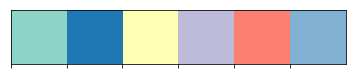

In [856]:
sns.palplot(index_color['color'].unique())
index_color['color'].unique()

In [857]:
group_0 =temp_3[temp_3.index.isin(clusters['C0'])].index.tolist()
group_1 =temp_3[temp_3.index.isin(clusters['#8dd3c7'])].index.tolist()
group_2 =temp_3[temp_3.index.isin(clusters['#ffffb3'])].index.tolist()
group_3 =temp_3[temp_3.index.isin(clusters['#bebada'])].index.tolist()
group_4 =temp_3[temp_3.index.isin(clusters['#fb8072'])].index.tolist()

In [621]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#8dd3c7'])]

In [622]:
genedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,ll


In [450]:
#genedf.mean(axis=0)

In [451]:
comparison_df = pd.DataFrame(genedf.median(axis=0),columns=['1'])

In [452]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#ffffb3'])]

In [453]:
#genedf.mean(axis=0)

In [454]:
comparison_df['2'] = pd.DataFrame(genedf.median(axis=0),columns=['2'])

In [455]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#bebada'])]

In [456]:
#genedf.mean(axis=0)

In [457]:
comparison_df['3'] = pd.DataFrame(genedf.median(axis=0),columns=['3'])

In [458]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#fb8072'])]

In [459]:
#genedf.mean(axis=0)

In [460]:
comparison_df['4'] = pd.DataFrame(genedf.median(axis=0),columns=['4'])

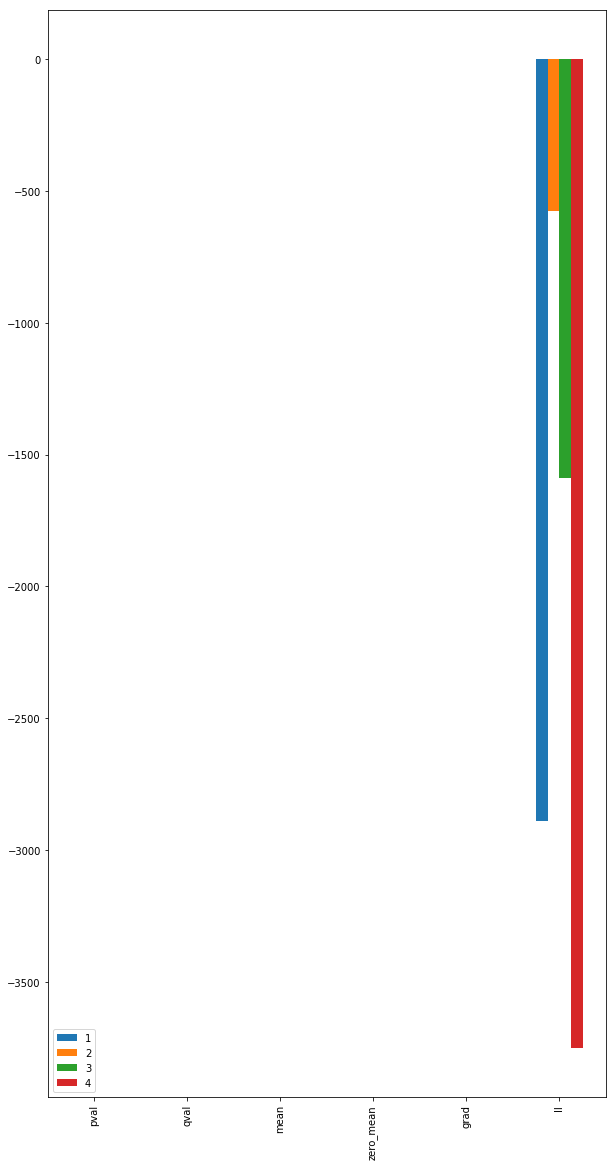

In [660]:
comparison_df.drop(['log2fc'],axis=0).plot.bar()